## S conditioned on H distribution

In [34]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

#%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rand
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from pandas.plotting import autocorrelation_plot as autocorr
import pandas as pd

import statsmodels as sm
import seaborn as sns

from lib.lif import LIF, ParamsLIF, LSM, ParamsLSM
from lib.causal import causaleffect, causaleffect_linear

Populating the interactive namespace from numpy and matplotlib


In [75]:
q = 3                      #Dimension of learnt vector
dt = 0.001                 #Simulation timestep
DeltaT = 50               #Number of timebins over which learning rule is applied
tsim = 1000                #Total simulation time
T = int((tsim/dt)/DeltaT)  #Number of learning blocks
Nsims = 3                  #Number of repeated simulations
x_input = 0                #Input
n = 2                      #Number of neurons
sigma = 10                 #Their noise level
sigma_perturb = 20        #Perturbation noise level
mu = 1                     #Spiking threshold
tau = 1                    #Neuron timescale
eta = 1                    #Cost gradient learning rate (RDD)
epsilon = 2e5              #Weight learning rate (RDD)
epsilon_np = 1e-1          #Weight learning rate (NP)
epsilon_np_baseline = 1e-1 #Weight learning rate with baseline (NP)
tau_s = 0.20               #Output filter timescale

c = 0.99                   #Correlation coefficient
p = 0.1                    #Learning window

N = 19
wmax = 20
wmin = 2

sigma = 10
mu = 1
tau = 1
params = ParamsLIF(sigma = sigma, mu = mu, tau = tau)
t = 500
lif = LIF(params, t = t)

In [112]:
print 1./DeltaT*(1 - np.exp(-DeltaT*dt/(tau_s)))/2
print exp_filter[0]

0.00221199216929
0.0025150289023


In [76]:
#Simulate for 500s, plot ISI distribution for a set of weights
w = np.array([10, 12])

lif.W = w
(v, h, _, _, u) = lif.simulate()

#Compute s
len_h = h.shape[1]
t_filter = np.linspace(0, 1, 2000)
exp_filter = np.exp(-t_filter/tau_s)
exp_filter = exp_filter/np.sum(exp_filter)
ds = exp_filter[0]
s1 = np.convolve(h[0,:], exp_filter)[0:len_h]
s2 = np.convolve(h[1,:], exp_filter)[0:len_h]

In [77]:
#Reshape s1 and h
s_r = s1[:].reshape((-1, DeltaT))
S = np.squeeze(s_r[:,-1])

s_r2 = s2[:].reshape((-1, DeltaT))
S2 = np.squeeze(s_r2[:,-1])

H_r = h[0,:].reshape((-1, DeltaT))
H = np.max(H_r, 1)

H_r2 = h[1,:].reshape((-1, DeltaT))
H2 = np.max(H_r2, 1)

## Is stationary distribution of S1 shifted by a fixed amount in spiking bins?

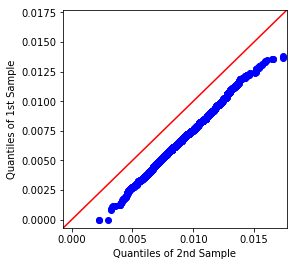

In [100]:
nsamps = min(np.sum(H == 0), np.sum(H == 1))
fig,ax1 = plt.subplots(1,1,figsize = (4,4))
sm.graphics.gofplots.qqplot_2samples(np.random.choice(S[H == 0], nsamps), np.random.choice(S[H == 1], nsamps), line='45', ax = ax1)
plt.savefig('./fig_s1_a.pdf')

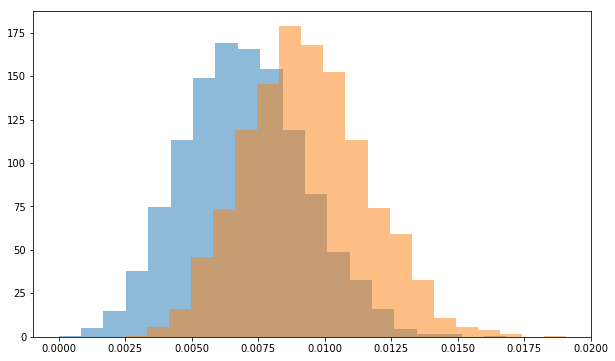

In [51]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(S[H == 0], 20, normed=1, alpha = 0.5);
ax1.hist(S[H == 1], 20, normed=1, alpha = 0.5);

## Is offset robust to changes in firing rate?

In [58]:
## Is the offset robust to changes in firing rate?
N = 20
wvals = np.linspace(2, 20, N)

c = 0.99
diffsc_0_99 = np.zeros(N)
ratesc_0_99 = np.zeros(N)

lif.params.c = c

for idx, wval in enumerate(wvals):
    print idx
    lif.W[0] = wval
    (v, h, _, _, u) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:len_h]
    s_r = s1[:].reshape((-1, DeltaT))
    S = np.squeeze(s_r[:,-1])
    H_r = h[0,:].reshape((-1, DeltaT))
    H = np.sum(H_r, 1)
    diffsc_0_99[idx] = np.mean(S[H == 1]) - np.mean(S[H == 0])
    ratesc_0_99[idx] = np.sum(h)
    
diffsc_0_01 = np.zeros(N)
ratesc_0_01 = np.zeros(N)

c = 0.01
lif.params.c = c

for idx, wval in enumerate(wvals):
    print idx
    lif.W[0] = wval
    (v, h, _, _, u) = lif.simulate()
    s1 = np.convolve(h[0,:], exp_filter)[0:len_h]
    s_r = s1[:].reshape((-1, DeltaT))
    S = np.squeeze(s_r[:,-1])
    H_r = h[0,:].reshape((-1, DeltaT))
    H = np.sum(H_r, 1)
    diffsc_0_01[idx] = np.mean(S[H == 1]) - np.mean(S[H == 0])
    ratesc_0_01[idx] = np.sum(h)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


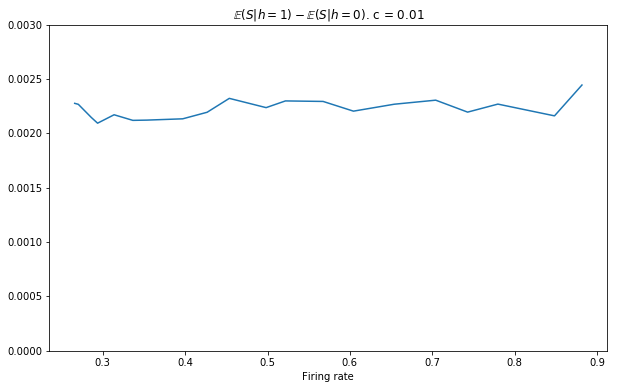

In [54]:
plt.plot(rates/tsim, diffs)
plt.ylim([0, 0.003])
plt.title("$\mathbb{E}(S|h= 1) - \mathbb{E}(S|h=0)$. c = 0.01")
plt.xlabel("Firing rate")

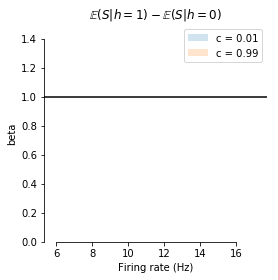

In [149]:
fig,ax1 = plt.subplots(1,1,figsize = (4,4))
ds1 = exp_filter[0]
ds = 1./DeltaT*(1 - np.exp(-DeltaT*dt/(tau_s)))/2
#ds = 1/T*(1 - np.exp(-T/tauS))
sns.tsplot(data = diffsc_0_99/ds, time = ratesc_0_99/tsim, ax = ax1)
sns.tsplot(data = diffsc_0_01/ds, time = ratesc_0_01/tsim, ax = ax1, color = 'C1')
ax1.set_xlabel("Firing rate (Hz)")
ax1.set_ylim([0, 1.5]);
ax1.set_ylabel('beta')
ax1.set_title("$\mathbb{E}(S|h= 1) - \mathbb{E}(S|h=0)$")
sns.despine(ax = ax1, trim = True)
ax1.legend({'c = 0.01', 'c = 0.99'})
plt.savefig('./fig_s1_c.pdf')
ax1.axhline(y = 1, color = (0,0,0))

## What is the theoretical term $\Delta_s$?

In [150]:
#Compute causal effect for range of DeltaT and tau_s values
N = 51
deltas = np.array([10, 20, 50, 100, 200])
M = deltas.shape[0]
tauss = np.logspace(-2, -0.5, N)

#Run a long simulation
lif.W = w
(v, h, _, _, u) = lif.simulate()

#Compute s
len_h = h.shape[1]

ce = np.zeros((M,N))
ce_theory = np.zeros((M,N))

#Convolve according to taus, bin according to deltas, compute causal effect
for idx, DeltaT in enumerate(deltas):
    for idx2, tau_s in enumerate(tauss):
        t_filter = np.linspace(0, 5, 5000)
        exp_filter = np.exp(-t_filter/tau_s)
        exp_filter = exp_filter/np.sum(exp_filter)
        ds = exp_filter[0]
        s1 = np.convolve(h[0,:], exp_filter)[0:len_h]
        s_r = s1[:].reshape((-1, DeltaT))
        S = np.squeeze(s_r[:,-1])
        H_r = h[0,:].reshape((-1, DeltaT))
        H = np.sum(H_r, 1)
        ce[idx,idx2] = np.mean(S[H == 1]) - np.mean(S[H == 0])
        #Compare this to the theoretcal effect
        ce_theory[idx,idx2] = 1./DeltaT*(1 - np.exp(-DeltaT*dt/(tau_s)))

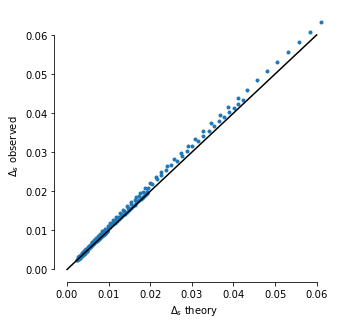

In [152]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.plot(ce.reshape((-1,1)), ce_theory.reshape((-1,1)), '.')
ax.plot([0,0.06], [0, 0.06], 'k')
ax.set_xlabel('$\Delta_s$ theory')
ax.set_ylabel('$\Delta_s$ observed')
sns.despine(trim = True, ax = ax)
plt.savefig('./fig_s1_d.pdf')

In [180]:
#Plot the deltas surface as a function of DeltaT and tau_s
N = 51
M = 51
deltas = np.linspace(10, 100, M)
#tauss = np.logspace(-2, -1, N)
tauss = np.linspace(0.01, 0.1, N)
ce_theory = np.zeros((M,N))

for idx, DeltaT in enumerate(deltas):
    for idx2, tau_s in enumerate(tauss):
        ce_theory[idx,idx2] = 1./DeltaT*(1 - np.exp(-DeltaT*dt/(tau_s)))

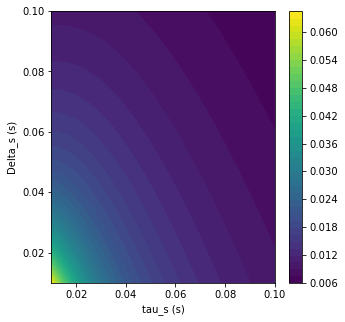

In [183]:
#Plot it
fig, ax = plt.subplots(1, 1, figsize = (5,5))
a = ax.contourf(ce_theory, 40, extent = [0.01, .1, 10*dt, 100*dt])
plt.colorbar(a)
ax.set_xlabel('tau_s (s)')
ax.set_ylabel('Delta_s (s)')
ax.set_title('')
plt.savefig('./fig_s1_e.pdf')